In [6]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 

from typing import Any, Optional, List

import qubx
%qubxd dev 

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.core.strategy import IStrategy, StrategyContext, TriggerEvent
from qubx.pandaz.utils import *

# - - - - - - - - - - - - - - - - - - - - - - - -
from qubx.trackers import PortfolioRebalancerTracker
from qubx.core.series import Quote
from qubx.ta.indicators import sma, ema
from qubx.data.readers import CsvStorageDataReader, MultiQdbConnector, AsTimestampedRecords, AsQuotes, RestoreTicksFromOHLC
from qubx.core.basics import Deal, Instrument, Order, Position, Signal
from qubx.core.utils import recognize_time

from qubx.impl.ccxt_connector import CCXTExchangesConnector
from qubx.impl.ccxt_trading import CCXTTradingConnector
from qubx.utils.runner import get_account_config

def Q(time: str, bid: float, ask: float) -> Quote:
    return Quote(recognize_time(time), bid, ask, 0, 0)

# r = CsvStorageDataReader("../tests/data/csv")
r = MultiQdbConnector('xlydian-data')

from qubx import QubxLogConfig

 >  [dev] installing cython rebuilding hook
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
class TestStrategy(IStrategy):
    capital_invested: int = 1000
    timeframe: str = '1Min'

    def on_start(self, ctx: StrategyContext):
        logger.info(f" -> Strategy started | {ctx.time()}")

    def on_fit(self, ctx: 'StrategyContext', fit_time: str | pd.Timestamp, previous_fit_time: str | pd.Timestamp | None = None):
        logger.info(f" -> Fit is called | fit_time: {fit_time} / prev: {previous_fit_time}")

    def on_event(self, ctx: StrategyContext, event: TriggerEvent) -> List[Signal] | None:
        logger.info(f" ||||| {event.time} -> {event} |||||")

        for i in ctx.instruments:
            logger.info(f"\t{i.symbol} : {ctx.broker_provider.get_quote(i.symbol)}")

            if True:
                ohlc = ctx.ohlc(i, self.timeframe)
                fast = ema(ohlc.close, 5)
                slow = ema(ohlc.close, 12)
                pos = ctx.positions[i.symbol].quantity
                if pos <= 0:
                    if (fast[0] > slow[0]) and (fast[1] < slow[1]):
                        # logger.info(f"\t{i.symbol} : buy")
                        ctx.trade(i, abs(pos) + i.min_size * 10)

                if pos >= 0:
                    if (fast[0] < slow[0]) and (fast[1] > slow[1]):
                        # logger.info(f"\t{i.symbol} : sell")
                        ctx.trade(i, -pos-i.min_size * 10)

        return None

    def ohlcs(self, timeframe:str) -> Dict[str, pd.DataFrame]:
        return {s.symbol: self.ctx.ohlc(s, timeframe).pd() for s in self.ctx.instruments}

    def on_stop(self, ctx: StrategyContext):
        logger.info(f" -> strategy is stopped")

    def tracker(self, ctx: StrategyContext) -> PortfolioRebalancerTracker:
        return PortfolioRebalancerTracker(ctx, 1000, 0)

# Simulated broker and paper trading

In [3]:
from qubx.backtester.simulator import SimulatedTrading

In [8]:
auth = get_account_config('binance-qbx', './configs/.env')

sim = SimulatedTrading('binance', 10000, 'vip0_usdt', 'USDT')
exch = CCXTExchangesConnector('binance', sim, **auth)

instruments = [lookup.find_symbol('BINANCE', 'BTCUSDT')]
ctx = StrategyContext(
    TestStrategy(), dict(
        timeframe='1Min',
    ), 
    exch, instruments=instruments,  # type: ignore
    md_subscription=dict(type='ohlc', timeframe='1Min', nback=0),
    trigger_spec='1Min -5Sec',
)
S = ctx.strategy

2024-07-19 12:57:49.247 [ ℹ️ ] binance initialized - current time 1970-01-01T00:00:00.000000000
2024-07-19 12:57:49.248 [ ⚠️ ] qubx.core.loggers:__init__:349 - Log writer is not defined - strategy activity will not be saved !
2024-07-19 12:57:49.248 [ ℹ️ ] (StrategyContext) set strategy parameters:
	set timeframe <- 1Min
2024-07-19 12:57:49.249 [ 🐞 ] Triggering strategy on every 1Min bar after 55S
2024-07-19 12:57:49.248 [ ⚠️ ] qubx.core.loggers:__init__:349 - Log writer is not defined - strategy activity will not be saved !
2024-07-19 12:57:49.248 [ ℹ️ ] (StrategyContext) set strategy parameters:
	set timeframe <- 1Min
2024-07-19 12:57:49.249 [ 🐞 ] Triggering strategy on every 1Min bar after 55S


In [ ]:
ctx.start()

In [ ]:
exch.get_historical_ohlcs('BTCUSDT', '5Min', 200)

In [ ]:
ctx.ohlc(ctx.instruments[0], '1Min')

In [6]:
print(exch.trading_service.get_position(instruments[0]))
print(exch.trading_service.get_orders())

??? [BINANCE:BTCUSDT]       0.00000      0.00    +0.0000 | nan        0.00
[]


In [13]:
ctx.trade('BTCUSDT', 0.1)

2024-07-19 13:35:58.845 [ ℹ️ ] (StrategyContext) sending market buy for 0.1 of BTCUSDT ...
2024-07-19 13:35:58.859 [ 🐞 ] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100001 MARKET BUY 0.1 executed at 64125.994999999995
2024-07-19 13:35:58.859 [ ℹ️ ]   ::  traded 0.1 for BTCUSDT @ 64125.994999999995 -> 0.00
2024-07-19 13:35:58.861 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100001 MARKET BUY 0.1 of BTCUSDT -> CLOSED


Order(id='SIM-ORDER-BTCUSDT-100001', type='MARKET', symbol='BTCUSDT', time=numpy.datetime64('2024-07-19T10:35:58.342475520'), quantity=0.1, price=0, side='BUY', status='CLOSED', time_in_force='gtc', client_id='TestStrategy_BTCUSDT_1', cost=0.0)

In [14]:
ctx.trade('BTCUSDT', -0.1)

2024-07-19 13:36:00.978 [ ℹ️ ] (StrategyContext) sending market sell for 0.1 of BTCUSDT ...
2024-07-19 13:36:00.991 [ 🐞 ] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100002 MARKET SELL 0.1 executed at 64125.985
2024-07-19 13:36:00.992 [ ℹ️ ]   ::  traded -0.1 for BTCUSDT @ 64125.985 -> -0.00
2024-07-19 13:36:00.992 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100002 MARKET SELL 0.1 of BTCUSDT -> CLOSED


Order(id='SIM-ORDER-BTCUSDT-100002', type='MARKET', symbol='BTCUSDT', time=numpy.datetime64('2024-07-19T10:36:00.241386240'), quantity=0.1, price=0, side='SELL', status='CLOSED', time_in_force='gtc', client_id='TestStrategy_BTCUSDT_2', cost=0.0)

In [183]:
ctx.trade('BTCUSDT', 0.1, 45000)

2024-07-19 12:34:40.521 [ ℹ️ ] (StrategyContext) sending limit buy for 0.1 of BTCUSDT ...
2024-07-19 12:34:40.522 [ 🐞 ] [OMS] BTCUSDT - registered SIM-ORDER-BTCUSDT-100003 LIMIT BUY 0.1 45000


Order(id='SIM-ORDER-BTCUSDT-100003', type='LIMIT', symbol='BTCUSDT', time=numpy.datetime64('2024-07-19T09:34:40.987281920'), quantity=0.1, price=45000, side='BUY', status='OPEN', time_in_force='gtc', client_id='TestStrategy_BTCUSDT_3', cost=0.0)

In [184]:
ctx.cancel('BTCUSDT')

2024-07-19 12:34:43.226 [ 🐞 ] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100003 LIMIT BUY 0.1 canceled
2024-07-19 12:34:43.227 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100003 LIMIT BUY 0.1 of BTCUSDT -> CANCELED
2024-07-19 12:34:43.227 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100003 LIMIT BUY 0.1 of BTCUSDT -> CANCELED


In [16]:
ctx.stop()
exch.close()

2024-07-19 13:37:02.809 [ ℹ️ ] (StrategyContext) Market data processing stopped
2024-07-19 13:37:02.825 [ ℹ️ ] (CCXTDataConnector) BTCUSDT OHLCV listening has been stopped
2024-07-19 13:37:02.825 [ ℹ️ ] (CCXTDataConnector) BTCUSDT OHLCV listening has been stopped
2024-07-19 13:37:02.828 [ ℹ️ ] (CCXTDataConnector) BTCUSDT execution reports listening has been stopped


2024-07-19 13:37:02.809 [ ℹ️ ]  -> strategy is stopped
2024-07-19 13:37:02.809 [ ℹ️ ] 	StrategyContext.handler took 0.0000023 secs
2024-07-19 13:37:02.809 [ ℹ️ ] 	loggers.notify took 0.0000025 secs
2024-07-19 13:37:02.809 [ ℹ️ ] 	StrategyContext._process_incoming_data took 0.0000214 secs
2024-07-19 13:37:02.809 [ ℹ️ ] 	CachedMarketDataHolder.update_by_bar took 0.0000592 secs
2024-07-19 13:37:02.809 [ ℹ️ ] 	StrategyContext._processing_bar took 0.0000764 secs
2024-07-19 13:37:02.809 [ ℹ️ ] 	strategy.on_fit took 0.0007883 secs
2024-07-19 13:37:02.821 [ ℹ️ ] 	CachedMarketDataHolder.get_ohlcv took 0.0000692 secs
2024-07-19 13:37:02.821 [ ℹ️ ] 	strategy.on_event took 0.0048913 secs
2024-07-19 13:37:02.821 [ ℹ️ ] 	StrategyContext.trade took 0.0033806 secs
2024-07-19 13:37:02.823 [ ℹ️ ] 	StrategyContext._processing_order took 0.0006886 secs
2024-07-19 13:37:02.824 [ ℹ️ ] 	StrategyContext._processing_deals took 0.0014585 secs
2024-07-19 13:37:02.809 [ ℹ️ ] 	StrategyContext.handler took 0.000002

# Simulated data provider

In [38]:
from qubx.backtester.simulator import SimulatedTrading, SimulatedExchange
from qubx.core.loggers import CsvFileLogsWriter, InMemoryLogsWriter

QubxLogConfig.set_log_level("ERROR")
# QubxLogConfig.set_log_level("DEBUG")

In [39]:
sbroker = SimulatedTrading('binance', 10000, 'vip0_usdt', 'USDT', '2024-01-01 00:00:00')
sdp = SimulatedExchange('binance', sbroker, r)

instruments = [lookup.find_symbol('BINANCE.UM', s) for s in ['BTCUSDT', ]]#'SOLUSDT', 'LINKUSDT']]

logs_writer = InMemoryLogsWriter('test', 'test', 'test')

ctx = StrategyContext(
    TestStrategy(), dict(timeframe='10Min'), 
    sdp, instruments=instruments,  # type: ignore
    md_subscription=dict(type='ohlc', timeframe='5Min', nback=0), # TODO: doesn't work if nback > 0 !!!
    trigger_spec='10Min -2Sec',
    logs_writer=logs_writer,
    # trigger_spec="*/10 * * * *"

)
ctx.start()

In [40]:
# %%time
d = sdp.run('2024-01-01 00:00', '2024-04-01 00:00')
ctx.stop()

  0%|          | 0/104836 [00:00<?, ?it/s]

In [14]:
# str(sbroker.get_position(instruments[2]))

'2024-02-01 00:04:59 [BINANCE.UM:LINKUSDT]       0.10    15.399    -0.9637 | 15.473        1.55'

In [41]:
# pfl = pd.read_csv("logs/Strategy3_Account1_portfolio.csv", index_col='timestamp', parse_dates=True)
pfl = logs_writer.get_portfolio()
exs = logs_writer.get_executions()

In [ ]:
exs.head()

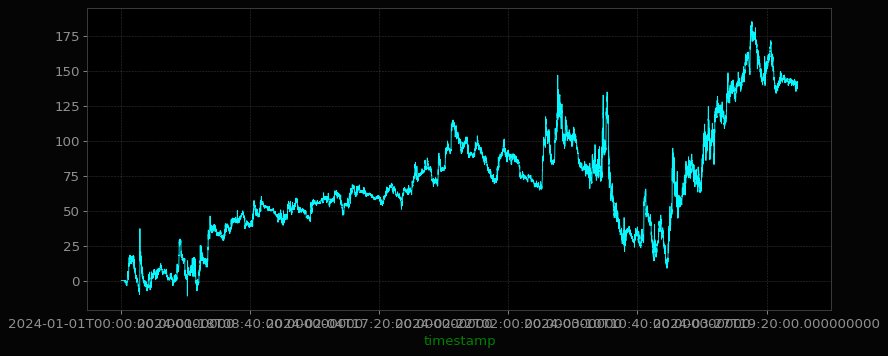

In [43]:
pfl[pfl['instrument_id'] == 'BTCUSDT'].pnl_quoted.plot();
# pfl[pfl['instrument_id'] == 'SOLUSDT'].pnl_quoted.plot()
# pfl[pfl['instrument_id'] == 'LINKUSDT'].pnl_quoted.plot()